# A Beginner’s Guide to Carry out Extreme Value Analysis (5) - IDF

As we know, Intensity Duration Frequency (IDF) curves are a standard tool routinely used in the planning and designing of municipal drainage, stormwater, flood management, and wastewater infrastructure. They are derived from historical rainfall records under the assumption of stationarity. 

Rainfall IDF curve information describes the frequency of extreme rainfall events for a variety of durations and intensities. Keep in mind that Depth Duration Frequency (DDF) curve is another kind of presentation format of IDF curve. They can be transformed from one to the other as $$Intensity = Depth/Duration $$

The following presents a primary procedure to create IDF curves in a more generalized format.

## 1. Load rainfall IDF data

### Import basic libs

In [1]:
import math
from pandas import *
import pandas as pd
from collections import OrderedDict

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12

### Load IDF data

IDF values can be obtained by analyzing annual maxima series for each duration, just as DDF values. However, it is generally difficult to get rainfall data with high temporal resolution such as at 5 and 30 minutes. 

For an illustration of creating IDF curves, the following IDF data is abstracted directly from a paper, where 
* The duration is in hour (0.25hr = 15 minutes). 
* The return years consist of 2,5,10,20,50 and 100. 
* The rainfall intensity is in mm/hr.

In [2]:
data  = pd.read_csv('data/IDFstn3117070.txt')
data  = data.set_index('Duration')
data

,2-yr,5-yr,10-yr,20-yr,50-yr,100-yr
Duration,,,,,,
0.25,155.1,177.7,196.9,218.2,249.9,276.9
0.50,103.8,118.9,131.8,146.0,167.2,185.3
1.00,64.6,74.0,82.0,90.8,104.1,115.3
3.00,27.9,31.9,35.4,39.2,44.9,49.7
6.00,15.9,18.2,20.2,22.4,25.7,28.4
12.00,9.0,10.3,11.4,12.7,14.5,16.1
24.00,5.1,5.8,6.4,7.1,8.2,9.0
48.00,2.8,3.3,3.6,4.0,4.6,5.1
72.00,2.0,2.3,2.6,2.9,3.3,3.6


## 2. Fit IDF data into empirical curve for each return year

The IDF data derived with above method is typically fitted to a continuous function in order to make the process of
IDF data interpolation more efficient. For example, 10 yr depth for duration of 45 min is not readily available in the published IDF data. In order to obtain this information, a generalized IDF relationship can be written in the form of

$$I = a*T^k/(D + b)^c$$

where $I$ is the rainfall intensity (mm/hr), $D$ is the rainfall duration (hr), $T$ is a specific return year, while and $a, b, c$ and $k$ are coefficients. 

### Fit IDF curves based the above formula

The Non-Linear Least-Squares Minimization and Curve-Fitting for Python (`lmfit`) is used to fit the above curve for each return year in 2, 5 10, 20, 50 and 100.

`lmfit` can be installed by running:

`pip install lmfit`

In [3]:
from lmfit import Model
from lmfit import Parameter
import re

#### Define the IDF function

In [4]:
def regidf(D, a, b, c,T, k):
    return a*T**k/(D+b)**c

#### Create a regression model based on the above IDF function
In the model, the dependent variable is intensity, while independent variables are duration and return years.

In [5]:
model = Model(regidf, independent_vars=['D','T'])

#### Fit IDF curves on all of return years
* regular expresson (re) is used to abstract return years from column names.
* initial guess of a,b,c,k is very important. Different initial guess may produce different regression parameters. May need a good method to estimate initial guess.

In [6]:
D = data.index*1.0
idfparams = OrderedDict()

for name in data.columns.values.tolist():    
    T = map(float, re.findall('\d+', name))   
    datax  =  data[name].values;
    result = model.fit(datax, 
                       D = D, 
                       T = Parameter(value=T[0], vary=False), 
                       a = datax.mean(),                                    
                       b = Parameter(value=1, min=0),
                       c = Parameter(value=1, min=0),
                       k = Parameter(value=1, min=0))
    idfparams[name] = [result.params['a'].value,result.params['b'].value,result.params['c'].value,result.params['k'].value]

fnl = pd.DataFrame.from_dict(idfparams, orient='index')
fnl.columns=["a","b","c","k"]
fnl   

,a,b,c,k
2-yr,43.491955,0.156419,0.837507,0.746463
5-yr,23.713464,0.156404,0.837906,0.782624
10-yr,29.725577,0.156819,0.838008,0.493790
20-yr,99.823552,0.155330,0.836736,0.008818
50-yr,4.575590,0.155459,0.836429,0.829554
100-yr,128.938307,0.156368,0.837793,0.002149


## 3.Draw IDF curves 

### Setup sample durations for interpolation and plotting 

Set 1000 durations from 0.25 to 72 hours to make IDF curves smoothly.

In [7]:
samdurations = np.linspace(0.25,72.0,1000)
samdurations[-5:]

array([ 71.71271271,  71.78453453,  71.85635636,  71.92817818,  72.        ])

### Use the IDF regression parameters to calculate IDF values of sample durations

In [8]:
fnlt = fnl.T

ddfvalues = OrderedDict()
for name in data.columns.values.tolist():     
    T = map(float, re.findall('\d+', name))
    ddfvalues[name] = regidf(samdurations,T=T, a= fnlt[name]["a"],b=fnlt[name]["b"],c=fnlt[name]["c"],k=fnlt[name]["k"],)
    
inh = pd.DataFrame.from_dict(ddfvalues, orient='index').T.set_index(samdurations) 
inh.tail()


,2-yr,5-yr,10-yr,20-yr,50-yr,100-yr
71.712713,2.033524,2.324969,2.577044,2.865990,3.288314,3.624788
71.784535,2.031824,2.323024,2.574888,2.863596,3.285568,3.621756
71.856356,2.030126,2.321082,2.572736,2.861206,3.282827,3.618730
71.928178,2.028432,2.319144,2.570587,2.858820,3.280091,3.615709
72.000000,2.026741,2.317210,2.568443,2.856439,3.277359,3.612694


#### Save the IDF values to idf.pickle for future use

In [1]:
inh.to_pickle('data/idf.pickle')

NameError: name 'inh' is not defined

### Have a visualization check

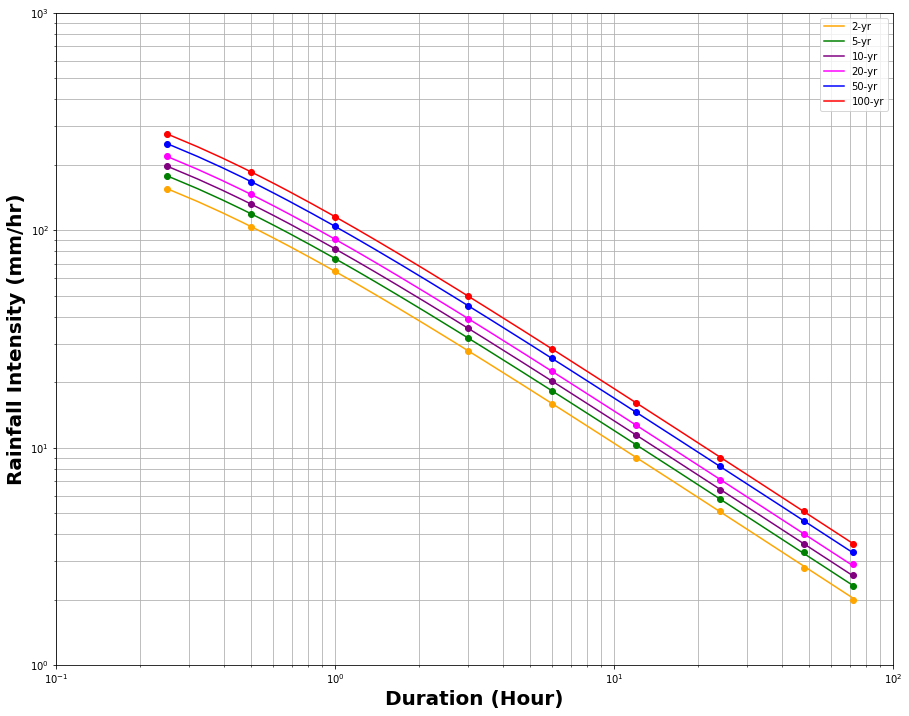

In [9]:
ag = inh.plot(color=['orange', 'green', 'purple', 'magenta', 'blue','red'])

ag.set_yscale('log')
ag.set_xscale('log')

ag = plt.plot(data['2-yr'],  "o", color="orange")
ag = plt.plot(data['5-yr'],  "o", color="green")
ag = plt.plot(data['10-yr'], "o", color="purple")
ag = plt.plot(data['20-yr'], "o", color="magenta")
ag = plt.plot(data['50-yr'], "o", color="blue")
ag = plt.plot(data['100-yr'],"o", color="red")

plt.xlim([0.1,100])
plt.ylim([1, 1000])
plt.grid(True,which="both", ls="-")

plt.xlabel("Duration (Hour)", fontsize=20, fontweight = 'bold')
plt.ylabel("Rainfall Intensity (mm/hr)", fontsize=20,fontweight = 'bold')

## End Notes

Through this guide I have tried to give you a basic idea how to carry out extreme value analysis (EVA) upon a time series data of interest.

In fact, the analysis will become more complicated in a real practice as high quality data are not always available. Sometimes, you have to spend a lot of time cleaning the data. For example, fill the missing values and check outliers.

In addition, carrying out EVA always fits several distributions, simultaneously. Then a goodness-of-fit measure (e.g., Anderson-Darling test) is used to select the optimal one. This also is the case for creating DDF or IDF curves.

Although a generalized IDF curve is fit in this part, there are several curves available for practical applications. These curves can also be fit using the library of Non-Linear Least-Squares Minimization and Curve-Fitting for Python (LMFIT). However, it is worth noting it is very import to estimate the inital values for each parameter of IDF curves. Different initial guess may produce different IDF parameters.

This is just a start. You can try more.